# BLU15 - Learning notebook - Part 2 of 2 - Model diagnosis and redeployment

In this notebook, we'll go back to the police vehicle search data set and think about the issues we identified in the first notebook.

In [1]:
import joblib
import pandas as pd
import json
import joblib
import pickle
import requests
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, roc_auc_score, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier

## 1. How to diagnose an existing model

As we've seen previously, it often happens that your data distribution changes with time. More than that, sometimes you don't know how a model was trained and what was the original training data.

As an example, we're going to use the same problem that you met in [BLU14](https://github.com/LDSSA/batch8-students/tree/main/S06%20-%20DS%20in%20the%20Real%20World/BLU14%20-%20Deployment%20in%20Real%20World).

>The police department has received lots of complaints about its stop and search policy. Every time a car is stopped, the police officers have to decide whether or not to search the car for contraband. According to critics, these searches have a bias against people of certain backgrounds.
>
>Your company has been hired to (1) determine whether the criticism is substantiated, and (2) create a service to fairly decide whether or not to search a car, based on objective data. This service will be used by police officers to request authorization to search, and your service will return a Yes or No answer.
>
>The police department has asked for the following requirements:
>
>- A minimum 50% success rate for searches (when a car is searched, it should be at least 50% likely that contraband is found).
>- No police department should have a discrepancy larger than 5% between the search success rates for the protected classes (race, ethnicity, gender)
> - The largest possible amount of contraband found, given the constraints above.

You received a trained model from your client and here is the model description:

> It's a [LightGBM model (LGBMClassifier)](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html) trained on the following features:
> - Department Name
> - InterventionLocationName
> - InterventionReasonCode
> - ReportingOfficerIdentificationID
> - ResidentIndicator
> - SearchAuthorizationCode
> - StatuteReason
> - SubjectAge
> - SubjectEthnicityCode
> - SubjectRaceCode
> - SubjectSexCode
> - TownResidentIndicator

- All the categorical features were one-hot encoded. The only numerical feature (SubjectAge) was not changed. 
- The rows that contain rare categorical features (the ones that appear less than N times in the dataset) were removed. 
- You can check the `original_model.ipynb` notebook for more details.

And here is the description of how the current model succeeds with the requirements:
- precision = 50.00%
- recall = 88.74%
- roc_auc_score = 88.00%

First, let's compare the client's model with the models that we created in the previous BLU:

| Model |   Baseline    |  Second iteration   | Client model  | Best model |
|-------------------|---------|--------|--------|--------| 
| Requirement 1 - success rate |     0.53  |  0.38  |   0.50 |  1 |
| Requirement 2 - global discrimination (race) |  0.105  |  0.11  |  NaN  |  1 |
| Requirement 2 - global discrimination (sex) | 0.012  | 0.014 |  NaN  | 1 |
| Requirement 2 - global discrimination (ethnicity) | 0.114  |  0.101   |  NaN  | 2 | 
| Requirement 2 - # department discrimination (race) | 27 |  17 |  NaN  | 2 |
| Requirement 2 - # department discrimination (sex) | 19 |  23 |  NaN  | 1 |
| Requirement 2 - # department discrimination (ethnicity) | 24 |  NaN  |  23  | 2 |
| Requirement 3 - contraband found (Recall) | 0.65  | 0.76  |   0.89   | 3 | 

As we can see, the client's model has the required success rate (Requirement 1) as we need, and a very good Recall (Requirement 3), but it might be risky to have the success rate so close to the threshold, as we might end up with a success rate <0.5 really quickly.

Let's imagine that the model was trained a long time ago. Models need to be constantly evaluated as data distribution is not always the same. Something that used to work even a year ago could be completely wrong today. And some years are more _different_ than others (looking at you 2020 and 2021). 

First of all, let's start the server which is running this model and then read a csv file with the latest observations. Open a terminal, navigate to the BLU15 directory, activate the S06 virtual environment, and start the server:
```sh
python3.12 protected_server.py
```

In [2]:
df = pd.read_csv('./data/new_observations.csv')
df.head()

,ContrabandIndicator,Department Name,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,False,farmington,unionville,V,400,False,I,Other,21,N,W,M,False
1,False,suffield,suffield,V,114,True,I,Registration,36,N,W,M,False
2,True,csp troop g,new haven,V,1000003362,True,C,Moving Violation,21,H,W,M,False
3,True,new canaan,new canaan,E,287,False,O,Defective Lights,14,H,W,M,True
4,False,stamford,stamford,V,3A NIGHTS,True,C,Seatbelt,37,N,W,M,False


Let's start by sending all these latest observations to the model and then compare the model prediction results with the target values. The model is already prepared to convert our observations to the format it's expecting, the only thing we need to change is making department and intervention location names lowercase and remove extra spaces.

In [3]:
# lowercase departments and location names
df['Department Name'] = df['Department Name'].astype(str).str.lower().str.strip()
df['InterventionLocationName'] = df['InterventionLocationName'].astype(str).str.lower().str.strip()

In [4]:
# our server is running on the localhost
url = "http://127.0.0.1:5000/predict"
headers = {'Content-Type': 'application/json'}

We'll make a function for sending a request:

In [5]:
def send_request(index: int, obs: dict, url: str, headers: dict):
    observation = {
      "id": index,
      "observation": {
          "Department Name": obs["Department Name"],
          "InterventionLocationName": obs["InterventionLocationName"],
          "InterventionReasonCode": obs["InterventionReasonCode"],
          "ReportingOfficerIdentificationID": obs["ReportingOfficerIdentificationID"],
          "ResidentIndicator": obs["ResidentIndicator"],
          "SearchAuthorizationCode": obs["SearchAuthorizationCode"],
          "StatuteReason": obs["StatuteReason"],
          "SubjectAge": obs["SubjectAge"],
          "SubjectEthnicityCode": obs["SubjectEthnicityCode"],
          "SubjectRaceCode": obs["SubjectRaceCode"],
          "SubjectSexCode": obs["SubjectSexCode"],
          "TownResidentIndicator": obs["TownResidentIndicator"]
      }
    }

    r = requests.post(url, data=json.dumps(observation), headers=headers)
    result = json.loads(r.text)
    return result

And send the requests for all the observations from our dataframe. This can take a while, you will see the responses coming in the terminal where you run the server.

In [6]:
responses = [send_request(i, obs, url, headers) for i, obs in df.iterrows()]

Let's look at our responses:

In [7]:
len(responses)

2000

In [8]:
print(responses[0])

{'prediction': False, 'proba': 0.15549770266577043}


We'll add our probabilities to the dataframe and convert them to class labels by setting a threshold:

In [9]:
df['proba'] = [r['proba'] for r in responses]
threshold = 0.20428237445800884
# we're going to use the threshold we got from the client
df['prediction'] = [1 if p >= threshold else 0 for p in df['proba']]

We want to know how good are these predictions from the new observations:

In [10]:
confusion_matrix(df['ContrabandIndicator'], df['prediction'])

array([[490, 698],
       [304, 508]])

If you remember from S01, this is how you interpret a confusion matrix, and ours is not looking too good:

<img src="./media/confusion_matrix.jpg" alt="drawing" width="300"/>

We can check the client requirement of:
> A minimum 50% success rate for searches (when a car is searched, it should be at least 50% likely that contraband is found)

so, precision above 50%. This function does that for us:

In [11]:
def verify_success_rate_above(y_true, y_pred, min_success_rate=0.5):
    """
    Verifies that the success rate of the predictions is above a provided minimum
    """
    
    precision = precision_score(y_true, y_pred, pos_label=True)
    is_satisfied = (precision >= min_success_rate)
    
    return is_satisfied, precision

In [12]:
verify_success_rate_above(df['ContrabandIndicator'], df['prediction'], 0.5)

(np.False_, np.float64(0.42122719734660036))

<img src="./media/e39.jpg" alt="danger" width="500"/>


What about the next requirement?

> The largest possible amount of contraband found, given the constraints above.

The client said their model recall was 0.8874. Is it still true?

In [13]:
def verify_amount_found(y_true, y_pred):
    """
    Verifies the amout of contraband found in the test dataset - a.k.a the recall in our test set
    """
    
    recall = recall_score(y_true, y_pred, pos_label=True)    
    return recall

In [14]:
verify_amount_found(df['ContrabandIndicator'], df['prediction'])

np.float64(0.625615763546798)

<img src="./media/no.png" alt="no" width="270"/>

Okay, relax, it happens. Let's start from checking different thresholds. Maybe the selected probability threshold doesn't work anymore. Let's try 0.25.

In [15]:
threshold = 0.25
df['prediction'] = [1 if p >= threshold else 0 for p in df['proba']]

In [16]:
verify_success_rate_above(df['ContrabandIndicator'], df['prediction'], 0.5)

(np.False_, np.float64(0.41))

In [17]:
verify_amount_found(df['ContrabandIndicator'], df['prediction'])

np.float64(0.5049261083743842)

<img src="./media/poker.jpg" alt="drawing" width="150"/>

Let's try the same technique to identify the best threshold as they originally did. Maybe we can find something good enough. 

It's not a good idea to verify such things on the test data, but we're going to use it just to confirm the model's performance, not to select the threshold.

In [18]:
precision, recall, thresholds = precision_recall_curve(df['ContrabandIndicator'], df['proba'])

In [19]:
precision = precision[:-1]
recall = recall[:-1]

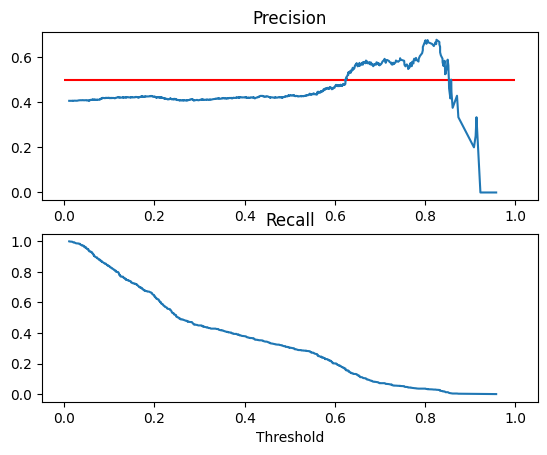

In [20]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.sharex(ax2)
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax2.set_title('Recall');

So what do we see? There is some threshold value (around 0.6) that gives us precision >= 0.5, but the threshold is so high, that the recall at this point is really, really low.

Let's calculate the exact values for the probability threshold and the recall:

In [21]:
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
thresholds[min_index], recall[min_index]

(np.float64(0.623937089535738), np.float64(0.16379310344827586))

OUCH! Before we move on, we need to understand why this happens so that we can decide what kind of action to perform.

## 2. Identifying issues

Let's try to analyze the changes in the data and discuss what we can do to address the data drift. Below is the original data set used for the analysis, the 76743 data points for the vehicles that were searched.

In [22]:
old_df = pd.read_csv('./data/train_searched.csv')
old_df.head()

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,True,False,Bridgeport,10/01/2013 12:46:00 AM,Bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True
1,True,True,Milford,10/01/2013 01:50:00 AM,MILFORD,E,2325,True,I,Defective Lights,30.0,N,W,M,True
2,True,False,Torrington,10/01/2013 03:49:00 AM,Torrington,V,DACYR048,True,C,Registration,43.0,N,W,M,True
3,True,False,State Police,10/01/2013 05:30:00 AM,TOLLAND,V,1000002715,False,C,Other,19.0,N,B,M,False
4,True,False,Greenwich,10/01/2013 05:47:00 AM,RIVERSIDE,V,110993,False,N,Speed Related,34.0,M,B,M,False


We're going to preprocess this data set in the same way as for the original model and then compare it to the current data set to understand how it differs.

First we clean the department and intervention location names and select the columns to use as features.

In [23]:
# lowercase departments and location names, remove extra spaces
old_df['Department Name'] = old_df['Department Name'].str.lower().str.strip()
old_df['InterventionLocationName'] = old_df['InterventionLocationName'].str.lower().str.strip()

train_features = old_df.columns.drop(['VehicleSearchedIndicator', 'ContrabandIndicator'])
categorical_features = train_features.drop(['InterventionDateTime', 'SubjectAge'])
numerical_features = ['SubjectAge']
target = 'ContrabandIndicator'

Here we keep just the most frequent values and remove the rare ones:

In [24]:
# dictionary with the minimum required number of data points for each value in the given features
min_frequency = {
    "Department Name": 50,
    "InterventionLocationName": 50,
    "ReportingOfficerIdentificationID": 30,
    "StatuteReason": 10
}

def filter_values(df: pd.DataFrame, column_name: str, threshold: int):
    value_counts = df[column_name].value_counts()
    to_keep = value_counts[value_counts > threshold].index
    filtered = df[df[column_name].isin(to_keep)]
    return filtered

In [25]:
for feature, threshold in min_frequency.items():
    old_df = filter_values(old_df, feature, threshold)
print(old_df.shape)
old_df.head()

(46817, 15)


,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator
0,True,False,bridgeport,10/01/2013 12:46:00 AM,bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True
1,True,True,milford,10/01/2013 01:50:00 AM,milford,E,2325,True,I,Defective Lights,30.0,N,W,M,True
3,True,False,state police,10/01/2013 05:30:00 AM,tolland,V,1000002715,False,C,Other,19.0,N,B,M,False
11,True,True,state police,10/01/2013 12:41:00 PM,bridgeport,V,1000001904,True,O,Registration,20.0,N,B,M,True
12,True,True,west hartford,10/01/2013 12:44:00 PM,west hartford,V,1000002128,True,O,Other,23.0,N,W,M,False


Let's first check how much contraband we have in the two data sets:

In [26]:
old_df['ContrabandIndicator'].value_counts(normalize=True)

ContrabandIndicator
False    0.667813
True     0.332187
Name: proportion, dtype: float64

In [27]:
df['ContrabandIndicator'].value_counts(normalize=True)

ContrabandIndicator
False    0.594
True     0.406
Name: proportion, dtype: float64

Looks like we got a bit more contraband now. If the training data had a very different target feature distribution than the test set, the model's predictions might have a different distribution as well. It's a good practice to have the same target feature distribution in both training and test sets.

Let's investigate further and compare the department names present in both data sets:

In [28]:
new_department_names = df['Department Name'].unique()
old_department_names = old_df['Department Name'].unique()

unknown_departments = [department for department in new_department_names if department not in old_department_names]
len(unknown_departments)

10

In [29]:
df[df['Department Name'].isin(unknown_departments)].shape

(23, 15)

So we have 15 departments in the new data that the original model was not trained on, but they are only 23 rows from the test set. 

Let's repeat the same thing for the Intervention Location names.

In [30]:
new_location_names = df['InterventionLocationName'].unique()
old_location_names = old_df['InterventionLocationName'].unique()

unknown_locations = [location for location in new_location_names if location not in old_location_names]
len(unknown_locations)

30

In [31]:
df[df['InterventionLocationName'].isin(unknown_locations)].shape[0]

45

In [32]:
print('unknown locations: ', df[df['InterventionLocationName'].isin(unknown_locations)].shape[0] * 100 / df.shape[0], '%')

unknown locations:  2.25 %


Alright, there's a bit more of unknown locations, but still not some many samples. We don't know if this feature was important for the model, so we can't know if these 2.25% of unknown locations are important or not. But it's worth keeping it in mind.

Here are a few ideas of what we could try to do:

1. Reanalyze the filtered locations, e.g. filter more rare ones.
2. Create a new category for the rare locations
3. Analyze the unknown locations for containing typos

Let's go take a look on the relation between department names and the number of contrabands they find. We're going to select the most common department names, and then see the percentage of contraband indicator in each one for the training and test sets. We'll use the [crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html) function.

In [33]:
common_departments = df['Department Name'].value_counts().head(20).index
departments_new = df[df['Department Name'].isin(common_departments)]
departments_old = old_df[old_df['Department Name'].isin(common_departments)]

In [34]:
pd.crosstab(departments_old['ContrabandIndicator'], departments_old['Department Name'], normalize="columns")

Department Name,bridgeport,csp troop a,csp troop g,danbury,east hartford,enfield,glastonbury,manchester,new haven,norwalk,norwich,stamford,state police,stratford,vernon,wallingford,waterbury,west hartford,west haven,wethersfield
ContrabandIndicator,,,,,,,,,,,,,,,,,,,,
False,0.928666,0.666248,0.687755,0.927509,0.557677,0.658889,0.692217,0.51145,0.919422,0.653846,0.683516,0.835484,0.642674,0.718507,0.455538,0.467227,0.904637,0.33881,0.886396,0.568058
True,0.071334,0.333752,0.312245,0.072491,0.442323,0.341111,0.307783,0.48855,0.080578,0.346154,0.316484,0.164516,0.357326,0.281493,0.544462,0.532773,0.095363,0.66119,0.113604,0.431942


In [35]:
pd.crosstab(departments_new['ContrabandIndicator'], departments_new['Department Name'], normalize="columns")

Department Name,bridgeport,csp troop a,csp troop g,danbury,east hartford,enfield,glastonbury,manchester,new haven,norwalk,norwich,stamford,state police,stratford,vernon,wallingford,waterbury,west hartford,west haven,wethersfield
ContrabandIndicator,,,,,,,,,,,,,,,,,,,,
False,0.621622,0.527778,0.547619,0.540541,0.632653,0.5,0.75,0.65625,0.587719,0.729167,0.535714,0.666667,0.638298,0.583333,0.542857,0.538462,0.66129,0.426471,0.727273,0.516129
True,0.378378,0.472222,0.452381,0.459459,0.367347,0.5,0.25,0.34375,0.412281,0.270833,0.464286,0.333333,0.361702,0.416667,0.457143,0.461538,0.33871,0.573529,0.272727,0.483871


We can clearly see that some departments have a huge difference in the contraband indicator.

- Bridgeport used to have 93% of False contrabands, and now has only 62%.
- Similar situation with Danbury and New Haven. 

Why? Hard to say. There are really a lot of variables here. Maybe the departments got instructed on how to look for contraband. But it's getting clearer that we might need to retrain the model. 

Let's review InterventionLocationName next.

In [36]:
common_location = df['InterventionLocationName'].value_counts().head(20).index
locations_new = df[df['InterventionLocationName'].isin(common_location)]
locations_old = old_df[old_df['InterventionLocationName'].isin(common_location)]

In [37]:
pd.crosstab(locations_old['ContrabandIndicator'], locations_old['InterventionLocationName'], normalize="columns")

InterventionLocationName,bridgeport,danbury,east hartford,enfield,glastonbury,hartford,manchester,milford,new britain,new haven,norwalk,norwich,stamford,stratford,vernon,wallingford,waterbury,west hartford,west haven,wethersfield
ContrabandIndicator,,,,,,,,,,,,,,,,,,,,
False,0.821319,0.827001,0.56686,0.651386,0.696101,0.716981,0.5189,0.681979,0.555556,0.881922,0.652928,0.681746,0.821839,0.717748,0.478686,0.471781,0.869098,0.346905,0.86152,0.583201
True,0.178681,0.172999,0.43314,0.348614,0.303899,0.283019,0.4811,0.318021,0.444444,0.118078,0.347072,0.318254,0.178161,0.282252,0.521314,0.528219,0.130902,0.653095,0.13848,0.416799


In [38]:
pd.crosstab(locations_new['ContrabandIndicator'], locations_new['InterventionLocationName'], normalize="columns")

InterventionLocationName,bridgeport,danbury,east hartford,enfield,glastonbury,hartford,manchester,milford,new britain,new haven,norwalk,norwich,stamford,stratford,vernon,wallingford,waterbury,west hartford,west haven,wethersfield
ContrabandIndicator,,,,,,,,,,,,,,,,,,,,
False,0.603774,0.603774,0.642857,0.512195,0.75,0.611111,0.65625,0.633333,0.545455,0.583333,0.730769,0.557377,0.657895,0.555556,0.571429,0.552239,0.625,0.449275,0.714286,0.545455
True,0.396226,0.396226,0.357143,0.487805,0.25,0.388889,0.34375,0.366667,0.454545,0.416667,0.269231,0.442623,0.342105,0.444444,0.428571,0.447761,0.375,0.550725,0.285714,0.454545


What do we see?

- The InterventionLocationName and the Department Name are often the same.

It sounds pretty logical, as probably the police usually works in the area of their department. But we could try to create a feature saying whether InterventionLocationName is equal to the Department Name. Or maybe we could just get rid of one of them, if all the values are equal.

- There are similar changes in the Contraband distribution as in Department Name case.

Let's continue with reviewing the InterventionReasonCode.

In [39]:
pd.crosstab(old_df['ContrabandIndicator'], old_df['InterventionReasonCode'], normalize="columns")

InterventionReasonCode,E,I,V
ContrabandIndicator,,,
False,0.649917,0.648123,0.673714
True,0.350083,0.351877,0.326286


In [40]:
pd.crosstab(df['ContrabandIndicator'], df['InterventionReasonCode'], normalize="columns")

InterventionReasonCode,E,I,V
ContrabandIndicator,,,
False,0.598187,0.623457,0.589914
True,0.401813,0.376543,0.410086


There are some small changes, but they don't seem to be significant. Especially that all the 3 values have around a third of Contraband.

Time for officers!

In [41]:
df['ReportingOfficerIdentificationID'].value_counts()

ReportingOfficerIdentificationID
1000002072    13
790642042     12
625           10
30252          9
73             8
              ..
671622127      1
DCA0369        1
007            1
100000342      1
804            1
Name: count, Length: 1166, dtype: int64

In [42]:
filter_values(df, 'ReportingOfficerIdentificationID', 2)['ReportingOfficerIdentificationID'].nunique()

206

It looks like there are a lot of unique values for the officer id (1166 for 2000 records), and there are not so many common ones (only 206 officers have more than 2 rows in the dataset) so it doesn't make much sense to analyze it.

Let's make this a little less painful and go through the rest of the columns in one go!

In [43]:
rest = ['ResidentIndicator', 'SearchAuthorizationCode',
        'StatuteReason', 'SubjectEthnicityCode',
        'SubjectRaceCode', 'SubjectSexCode','TownResidentIndicator']

for col in rest:
    display(pd.crosstab(old_df['ContrabandIndicator'], old_df[col], normalize="columns"))
    display(pd.crosstab(df['ContrabandIndicator'], df[col], normalize="columns"))

ResidentIndicator,False,True
ContrabandIndicator,,
False,0.630182,0.671034
True,0.369818,0.328966


ResidentIndicator,False,True
ContrabandIndicator,,
False,0.604775,0.58748
True,0.395225,0.41252


SearchAuthorizationCode,C,I,N,O
ContrabandIndicator,,,,
False,0.752286,0.891968,0.857505,0.459395
True,0.247714,0.108032,0.142495,0.540605


SearchAuthorizationCode,C,I,N,O
ContrabandIndicator,,,,
False,0.569602,0.642857,0.635417,0.585642
True,0.430398,0.357143,0.364583,0.414358


StatuteReason,Administrative Offense,Cell Phone,Defective Lights,Display of Plates,Equipment Violation,Moving Violation,Other,Other/Error,Registration,STC Violation,Seatbelt,Speed Related,Stop Sign,Suspended License,Traffic Control Signal,Unlicensed Operation,Window Tint
ContrabandIndicator,,,,,,,,,,,,,,,,,
False,0.750149,0.66631,0.631676,0.664523,0.589041,0.628808,0.613269,0.623325,0.790641,0.745455,0.584138,0.619318,0.682819,0.837838,0.71436,0.798408,0.668078
True,0.249851,0.33369,0.368324,0.335477,0.410959,0.371192,0.386731,0.376675,0.209359,0.254545,0.415862,0.380682,0.317181,0.162162,0.28564,0.201592,0.331922


StatuteReason,Administrative Offense,Cell Phone,Defective Lights,Display of Plates,Equipment Violation,Moving Violation,Other,Other/Error,Registration,STC Violation,Seatbelt,Speed Related,Stop Sign,Suspended License,Traffic Control Signal,Unlicensed Operation,Window Tint
ContrabandIndicator,,,,,,,,,,,,,,,,,
False,0.653543,0.519231,0.593607,0.659722,0.458333,0.521552,0.618705,0.698113,0.626214,0.55,0.54386,0.565574,0.583333,0.536585,0.55914,0.529412,0.670588
True,0.346457,0.480769,0.406393,0.340278,0.541667,0.478448,0.381295,0.301887,0.373786,0.45,0.45614,0.434426,0.416667,0.463415,0.44086,0.470588,0.329412


SubjectEthnicityCode,H,M,N
ContrabandIndicator,,,
False,0.723222,0.685268,0.65069
True,0.276778,0.314732,0.34931


SubjectEthnicityCode,H,M,N
ContrabandIndicator,,,
False,0.617068,0.730769,0.584707
True,0.382932,0.269231,0.415293


SubjectRaceCode,A,B,I,W
ContrabandIndicator,,,,
False,0.688172,0.705339,0.717742,0.651314
True,0.311828,0.294661,0.282258,0.348686


SubjectRaceCode,A,B,I,W
ContrabandIndicator,,,,
False,0.578947,0.603648,0.571429,0.59008
True,0.421053,0.396352,0.428571,0.40992


SubjectSexCode,F,M
ContrabandIndicator,,
False,0.680998,0.664873
True,0.319002,0.335127


SubjectSexCode,F,M
ContrabandIndicator,,
False,0.561828,0.601351
True,0.438172,0.398649


TownResidentIndicator,False,True
ContrabandIndicator,,
False,0.645827,0.701935
True,0.354173,0.298065


TownResidentIndicator,False,True
ContrabandIndicator,,
False,0.6,0.587368
True,0.4,0.412632


We see that all the columns have changed, but they don't seem to be as significant as for the Departments.

Anyway, it seems like we need to retrain the model. It's what we were hired for! ;)

<img src="./media/retrain.jpg" alt="drawing" width="400"/>

## 3. Redeploy the model

Retrainining a model is always a decision that we need to think about. Especially, we need to consider the following points.

Was the change in the data permanent, temporary or seasonal? In other words, do we expect the data distribution to stay as it is? To change back? To change from season to season? Depending on that, we could retrain the model differently:

- If it's a seasonality, we might want to add features like season or month and train the same model to predict differently depending on the season. We could also investigate time series prediction algorithms.

- If it's something that is going to change back, we might train a new model for this particular period. Otherwise, if we expect the data distribution change here and back from time to time (and we know these periods in advance), we could create a new feature that would help the model understand which period it is in.

E.g. if we had a task of predicting beer consumption and had a city that has a lot of football matches, we might add a feature like _football_championship_ and make the model predict differently for these occasions. 

- If the data distribution has changed and we know that it's never going to come back, we can simply retrain the model.

But in some cases we have no idea why some changes happened (e.g. in this case of departments having more contraband).

- In this case it might be a good idea to train a new model on the new dataset and create some monitoring for the distribution of this particular feature so that we can react when things change again.

In our case we don't know what was the reason of the data distribution changes, so we'd like to train a model on the new dataset. The only thing is the size of the dataset. The original dataset had around 70k rows and our new set has only 2000. It's not enough to train a good model, so this time we're going to combine both datasets and add a new feature helping the model to distinguish between these periods. If we had more data, it would probably be better to train a completely new model.

In [44]:
old_df = pd.read_csv('./data/train_searched.csv')
old_df['is_new'] = False
df = pd.read_csv('./data/new_observations.csv')
df['is_new'] = True
df_combined = pd.concat([old_df, df], axis=0)
df_combined = df_combined.dropna()
df_combined['Department Name'] = df_combined['Department Name'].str.lower().str.strip()
df_combined['InterventionLocationName'] = df_combined['InterventionLocationName'].str.lower().str.strip()
df_combined

,VehicleSearchedIndicator,ContrabandIndicator,Department Name,InterventionDateTime,InterventionLocationName,InterventionReasonCode,ReportingOfficerIdentificationID,ResidentIndicator,SearchAuthorizationCode,StatuteReason,SubjectAge,SubjectEthnicityCode,SubjectRaceCode,SubjectSexCode,TownResidentIndicator,is_new
0,True,False,bridgeport,10/01/2013 12:46:00 AM,bridgeport,V,1207,True,I,Speed Related,37.0,H,W,M,True,False
1,True,True,milford,10/01/2013 01:50:00 AM,milford,E,2325,True,I,Defective Lights,30.0,N,W,M,True,False
2,True,False,torrington,10/01/2013 03:49:00 AM,torrington,V,DACYR048,True,C,Registration,43.0,N,W,M,True,False
3,True,False,state police,10/01/2013 05:30:00 AM,tolland,V,1000002715,False,C,Other,19.0,N,B,M,False,False
4,True,False,greenwich,10/01/2013 05:47:00 AM,riverside,V,110993,False,N,Speed Related,34.0,M,B,M,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76738,True,False,csp troop g,05/16/2018 01:30:00 AM,bridgeport,V,1000002598,True,O,Display of Plates,22.0,H,W,F,True,False
76739,True,False,east lyme,05/16/2018 01:37:00 AM,east lyme,V,WIL5967,True,C,Registration,63.0,N,W,F,False,False
76740,True,False,east lyme,05/16/2018 01:37:00 AM,east lyme,V,WIL5967,True,C,Registration,63.0,N,W,F,False,False
76741,True,False,east lyme,05/16/2018 01:50:00 AM,east lyme,V,LAN9374,True,C,Moving Violation,61.0,N,W,F,False,False


In [45]:
target = 'ContrabandIndicator'
train_features = df_combined.columns.drop(target)

df_train, df_test = train_test_split(df_combined, test_size=0.25, random_state=42, stratify=df_combined['is_new'])
X_train = df_train[train_features]
y_train = df_train[target]
X_test = df_test[train_features]
y_test = df_test[target]

In [46]:
categorical_features = df_combined.columns.drop(['ContrabandIndicator', 'SubjectAge'])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    LGBMClassifier(n_jobs=-1, random_state=42),
)

In [47]:
pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)
preds_proba = pipeline.predict_proba(X_test)[:, 1]
precision = precision_score(y_test, preds, pos_label=True)
recall = recall_score(y_test, preds)

print("precision: ", precision)
print("recall: ", recall)

[LightGBM] [Info] Number of positive: 19039, number of negative: 38497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2200
[LightGBM] [Info] Number of data points in the train set: 57536, number of used features: 1100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.330906 -> initscore=-0.704091
[LightGBM] [Info] Start training from score -0.704091
precision:  0.6541988850926093
recall:  0.5620268808898502


Things are looking much better! We passed the minimum precision test. The recall is lower, so we might go back to playing with the threshold on the probabilities. It's also still necessary to ensure that we're respecting all the other requirements, as we've done above. Next we could save our new model and re-deploy to the server, but we'll leave that for the exercise notebook. Good luck! 